# Import

In [9]:
# calcium traces exploration - simple commands in pandas
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
import scipy.stats
import os
import pickle
from matplotlib import cm
from matplotlib import ticker
from sklearn.model_selection import KFold, cross_validate, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.linear_model import RidgeClassifierCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import decomposition
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.utils import resample

# import cell mapping info

In [ ]:
"""
This script includes:
    -mapping local cells within sessions to global cells
    -computing correlation matrix of session by session for each time window (start, stimulus, response, 
    punishment, reward) - correlation between cell activities in a session with that of other sessions

---------
Python 3.8.5

Dependencies:
    -numpy 1.19.2
    -pandas 1.1.3
    -scipy 1.6.3
    -matplotlib 3.3.2
    -seaborn 0.11.0
    -sklearn 0.0
    -csv, os, pickle
"""

In [10]:
# change folder-/filenames
animal_folder_name = "/Users/felicia/Documents/CFIN/233/233_traces/"
filename = "registration_233.csv"

#session_list = ['04','06','07','08','10','11','12','13'] # 232
session_list = ['06','07','08','09','10','11','12','13'] # 233
#no_apf_sessions = [4,6,7,8,10,11,12,13] # 232
no_apf_sessions = [6,7,8,9,10,11,12,13] # 233

In [11]:
# import cell mapping information
global_cells = pd.read_csv(os.path.join(animal_folder_name, filename))
n_rows, n_columns = global_cells.shape

# drop unnecessary columns
global_cells = global_cells.drop('ncc_score', axis=1)
global_cells = global_cells.drop('centroid_distance', axis=1)
global_cells[0:10]

# local_cellset_index = session number
# global_cell_index = global cell number
# local_cell_index = local cell corresponding to global cell in this particular session

,global_cell_index,local_cell_index,local_cellset_index
0,0,0,0
1,0,0,1
2,0,11,2
3,0,0,3
4,0,0,4
5,0,0,5
6,0,0,6
7,0,1,7
8,0,1,8
9,0,40,9


In [12]:
# create matrix with global cell indeces and sessions - collect local cell index at corresponding global cell index
# cells that are not active in session are NaN
session = 0 # start at first session
# filter by session number:
global_sess = global_cells[global_cells['local_cellset_index']==session]
# append local cell index number for all active global cells in this session to dataframe:
global_cells_sess = pd.DataFrame(global_sess['global_cell_index'].values)
global_cells_sess.append(pd.Series(), ignore_index=True)
# insert NaN for all other global cells that do not appear in first session:
global_cells_sess.reindex(list(range(0, 136))).reset_index(drop=True)

# for each session (excl. first):
for session in range(1,14):
    # fill dataframe with NaNs for all sessions
    global_cells_sess[session] = np.nan
    # replace NaNs where global cells exist in session - with local cell index
    # for each global cell index:
    for idx in range(0,len(np.where(global_cells[:]['local_cellset_index']==session)[0])):
        # global cell index:
        idx_globcell = np.where(global_cells[:]['local_cellset_index']==session)[0][idx]
        # local cell index given global cell index:
        loccell = global_cells.loc[idx_globcell,'local_cell_index']
        # replace NaN in dataframe with local cell index in corresponding location
        global_cells_sess.loc[global_cells.loc[idx_globcell,'global_cell_index'], session] = loccell

<ipython-input-12-8010127a55e3>:8: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  global_cells_sess.append(pd.Series(), ignore_index=True)
<ipython-input-12-8010127a55e3>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  global_cells_sess.append(pd.Series(), ignore_index=True)


# correlation matrix: session by session (START)

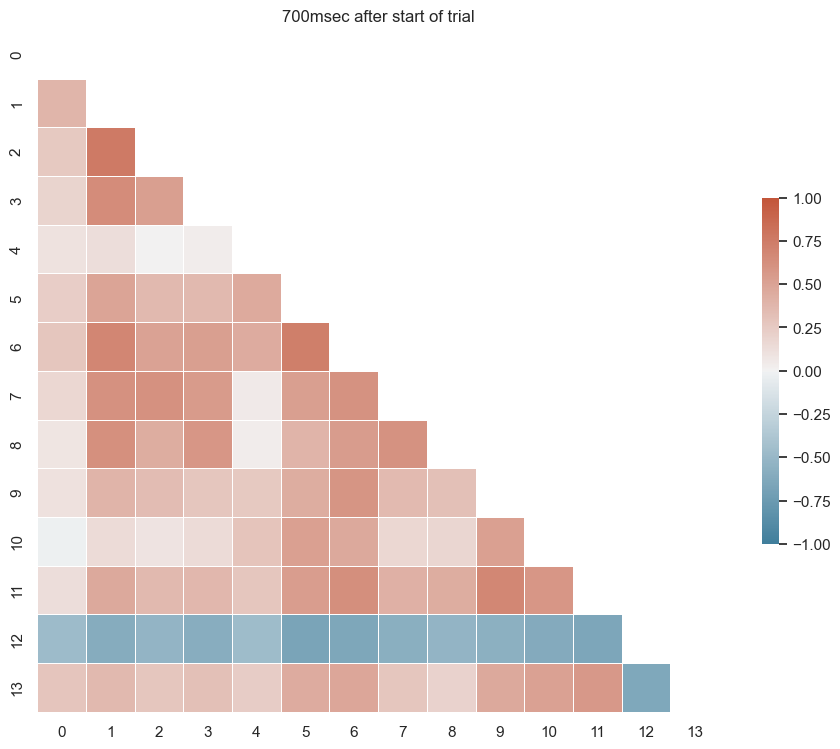

In [13]:
mean_activity_global = global_cells_sess.copy() # make copy of dataframe

# sessions without airpuff
for session in session_list: # non-airpuff sessions

    # load csv calcium traces
    folder_name = "Calcium_Traces/"
    filename = "2021-05-{0}.csv".format(session)
    df = pd.read_csv(os.path.join(animal_folder_name,folder_name, filename))
    n_rows, n_columns = df.shape

    # create time array
    df_times = df[' '][1:-1]
    df_num_time = pd.to_numeric(df_times, downcast='float')
    time_array = df_num_time.to_numpy()
    tot_timepoints = len(time_array)

    # check time sampling - i.e. if every data point is taken at the same "distance" in time from the next - or previous
    time_sampling = np.zeros(shape=(len(time_array)-1,))
    for i in range(1,len(time_array)):
        time_sampling[i-1] = time_array[i]-time_array[i-1]

    #12420 timepoints sampled at 100msec. means that every 10 of those timepoints is 1 sec
    sampling_rate = 0.1
    tot_secs = int(tot_timepoints * sampling_rate)

    # create channels array
    n_channels = n_columns-1
    channels_array = np.zeros(shape=(tot_timepoints, n_channels)) # initiate empty array
    # fill empty channels array
    for i in range(n_channels):
        col_name = df.columns[i+1]
        df_channel = df[col_name][1:-1]
        df_num_channel = pd.to_numeric(df_channel, downcast='float')
        channels_array[:,i] = df_num_channel.to_numpy()

    # load the behavioral data
    #folder_name = "trial_info" 
    #bhv_info_filename = "trial_info_2021-05-{0}.mat".format(session)
    #trial_info = scipy.io.loadmat(os.path.join(animal_folder_name,folder_name, bhv_info_filename))

    # extract information from trial_info: in matlab this is a struct with the fields:
    #trials_start_time = trial_info['trial_info'][0,0][0].ravel()
    #trials_stimulus_on = trial_info['trial_info'][0,0][1].ravel()
    #trials_response = trial_info['trial_info'][0,0][2].ravel()
    #trials_is_right_lick = trial_info['trial_info'][0,0][3].ravel()
    #trials_is_reward = trial_info['trial_info'][0,0][4].ravel()
    #trials_end_time = trial_info['trial_info'][0,0][5].ravel()
    #trials_finish_reward = trial_info['trial_info'][0,0][6].ravel()
    #n_trials = len(trials_end_time) # number of trials
    
    # load behavioural data (.pkl file)
    input_filename = "trial_info/trial_info_2021-05-{0}.pkl".format(session)
    with open(os.path.join(animal_folder_name,input_filename), 'rb') as fp:
         trial_info = pickle.load(fp)

    # extract information for trial_info: in PYTHON
    trials_start_time = np.array(trial_info['start_time'])
    trials_stimulus_on = np.array(trial_info['stimulus_on'])
    trials_response = np.array(trial_info['response'])
    trials_is_right_lick = np.array(trial_info['is_right_lick'])
    trials_is_reward = np.array(trial_info['is_reward'])
    trials_end_time = np.array(trial_info['end_trial'])
    n_trials = len(trials_end_time)

    # 500msec between start and stimulus onset
    new_start = [] # initiate empty list
    new_end = [] # initiate empty list
    new_start.append(trials_stimulus_on[0]-0.5) # append first start
    new_end.append(trials_stimulus_on[1]-0.5) # append first end
    for i in range(1,n_trials-1): # append start & end times for each trial (except last)
        new_start.append(trials_stimulus_on[i]-0.5)
        new_end.append(trials_stimulus_on[i+1]-0.5)
    new_start.append(trials_stimulus_on[n_trials-1]-0.5) # append last start
    new_end.append(trials_end_time[n_trials-1]) # append last end
    new_start = np.array(new_start) # turn list to array
    new_end = np.array(new_end)
    n_trials = len(new_end)
    
    # where was the stimulus? we don't have this info. But it can be reconstructed 
    stimulus_reconstruction = np.zeros(shape=(n_trials,))
    right_choice = np.where(trials_is_reward==1)[0]
    stimulus_reconstruction[right_choice] = trials_is_right_lick[right_choice]
    wrong_choice = np.where(trials_is_reward==0)[0]
    stimulus_reconstruction[wrong_choice] = 1 - trials_is_right_lick[wrong_choice]

    # split traces data by trials
    X = {}
    for i in range(n_trials-1):
        lower_bound = np.min(np.where(time_array>=new_start[i]))
        upper_bound = np.max(np.where(time_array<=new_end[i]))
        X[i] = channels_array[lower_bound:upper_bound,:]

    ##### mean neuron activity during time window
    start_timepoint = 0
    n_after_start = 7
    time_window = n_after_start+start_timepoint
    x = []
    selected_trials = ((new_end - new_start)/sampling_rate > 7.5)

    idx_idx = 0
    # for each trial:
    for idx in X:
        if selected_trials[idx_idx]==1:
            # append traces data within time window to x
            x.append(X[idx_idx][start_timepoint:n_after_start])
        idx_idx +=1
    x = np.mean(x, axis=0) # mean across trials
    x = np.mean(x, axis=0) # mean across time points in each time window for each neuron
    #print(x)
    
    session_int = int(session) # session as integer (instead of string)
    cur_sess = no_apf_sessions.index(session_int) # current session
    
    # get all local cell indeces for current session and sort in ascending order
    order_loccells = global_cells[global_cells['local_cellset_index']==cur_sess]['local_cell_index'].values.tolist()
    order_loccells.sort()
    
    # map local to global cell index in non-airpuff sessions
    # for each local cell in current session:
    for cell in order_loccells:
        # find local cell index in dataframe
        idx = np.where(mean_activity_global[:][cur_sess]==cell)[0][0]
        # replace index with cell activity
        mean_activity_global.loc[idx, cur_sess] = x[order_loccells.index(cell)] # replace cell number with mean activity

        
        
# for each airpuff session: 
for session in range(14,20):

    # LOAD CSV CALCIUM TRACES
    folder_name = "Calcium_Traces/"
    filename = "2021-05-{0}.csv".format(session)
    df = pd.read_csv(os.path.join(animal_folder_name,folder_name, filename))
    n_rows, n_columns = df.shape

    # create time array
    df_times = df[' '][1:-1]
    df_num_time = pd.to_numeric(df_times, downcast='float')
    time_array = df_num_time.to_numpy()
    tot_timepoints = len(time_array)

    # check time sampling - i.e. if every data point is taken at the same "distance" in time from the next - or previous
    time_sampling = np.zeros(shape=(len(time_array)-1,))

    #12420 timepoints sampled at 100msec. means that every 10 of those timepoints is 1 sec
    sampling_rate = 0.1
    tot_secs = int(tot_timepoints * sampling_rate)

    # create channels array
    n_channels = n_columns-1
    channels_array = np.zeros(shape=(tot_timepoints, n_channels)) # initiate empty array
    # fill empty channels array
    for i in range(n_channels):
        col_name = df.columns[i+1]
        df_channel = df[col_name][1:-1]
        df_num_channel = pd.to_numeric(df_channel, downcast='float')
        channels_array[:,i] = df_num_channel.to_numpy()

    # LOAD BEHAVIOURAL DATA
    #folder_name = "trial_info"
    #bhv_info_filename = "trial_info_2021-05-{0}.mat".format(session)
    #trial_info = scipy.io.loadmat(os.path.join(animal_folder_name,folder_name, bhv_info_filename))

    # extract information from trial_info: in matlab this is a struct with the fields:
    #trials_start_time = trial_info['trial_info'][0,0][0].ravel()
    #trials_stimulus_on = trial_info['trial_info'][0,0][1].ravel()
    #trials_response = trial_info['trial_info'][0,0][2].ravel()
    #trials_is_right_lick = trial_info['trial_info'][0,0][3].ravel()
    #trials_is_reward = trial_info['trial_info'][0,0][4].ravel()
    #trials_end_time = trial_info['trial_info'][0,0][5].ravel()
    #n_trials = len(trials_end_time) # number of trials
    
    # load behavioural data (.pkl file)
    input_filename = "trial_info/trial_info_2021-05-{0}.pkl".format(session)
    with open(os.path.join(animal_folder_name,input_filename), 'rb') as fp:
         trial_info = pickle.load(fp)

    # extract information for trial_info: in PYTHON
    trials_start_time = np.array(trial_info['start_time'])
    trials_stimulus_on = np.array(trial_info['stimulus_on'])
    trials_response = np.array(trial_info['response'])
    trials_is_right_lick = np.array(trial_info['is_right_lick'])
    trials_is_reward = np.array(trial_info['is_reward'])
    trials_end_time = np.array(trial_info['end_trial'])
    n_trials = len(trials_end_time)

    # 500msec between start and stimulus onset
    new_start = [] # initiate empty list
    new_end = [] # initiate empty list
    new_start.append(trials_stimulus_on[0]-0.5) # append first start
    new_end.append(trials_stimulus_on[1]-0.5) # append first end
    for i in range(1,n_trials-1): # append start & end times for each trial (except last)
        new_start.append(trials_stimulus_on[i]-0.5)
        new_end.append(trials_stimulus_on[i+1]-0.5)
    new_start.append(trials_stimulus_on[n_trials-1]-0.5) # append last start
    new_end.append(trials_end_time[n_trials-1]) # append last end
    new_start = np.array(new_start) # turn list to array
    new_end = np.array(new_end)
    n_trials = len(new_end)
    
    # where was the stimulus? we don't have this info. But it can be reconstructed 
    stimulus_reconstruction = np.zeros(shape=(n_trials,))
    right_choice = np.where(trials_is_reward==1)[0]
    stimulus_reconstruction[right_choice] = trials_is_right_lick[right_choice]
    wrong_choice = np.where(trials_is_reward==0)[0]
    stimulus_reconstruction[wrong_choice] = 1 - trials_is_right_lick[wrong_choice]

    # split traces data by trials
    X = {}
    for i in range(n_trials-1):
        lower_bound = np.min(np.where(time_array>=new_start[i]))
        upper_bound = np.max(np.where(time_array<=new_end[i]))
        X[i] = channels_array[lower_bound:upper_bound,:]
        
        
    ##### mean neuron activity during time window
    start_timepoint = 0
    n_after_start = 7
    x = []
    selected_trials = ((new_end - new_start)/sampling_rate > 7.5)
    
    idx_idx = 0
    # for each trial:
    for idx in X:
        if selected_trials[idx_idx]==1:
            # append traces data within time window to x
            x.append(X[idx_idx][start_timepoint:n_after_start])
        idx_idx +=1
    x = np.mean(x, axis=0) # mean across trials
    x = np.mean(x, axis=0) # mean of each neuron in this time window
            
    # get all local cell indeces for current session and sort in ascending order
    order_loccells = global_cells[global_cells['local_cellset_index']==session-6]['local_cell_index'].values.tolist()
    order_loccells.sort()
    
    # map local to global cell index in airpuff sessions
    # for each local cell in current session:
    for cell in order_loccells:
        # find local cell index in dataframe
        idx = np.where(mean_activity_global[:][session-6]==cell)[0][0]
        # replace index with cell activity
        mean_activity_global.loc[idx, session-6] = x[order_loccells.index(cell)] # replace cell number with mean activity

# NaN means no cell activity in that session = 0
mean_activity_global = mean_activity_global.fillna(0)
        
# correlation matrix session by session
cov = np.cov(mean_activity_global, rowvar=False)
    
### plot correlation matrix of channels: start of trial
sns.set_theme(style="white")
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(pd.DataFrame(cov).corr(), dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(pd.DataFrame(cov).corr(), mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=-1, vmax=1)
ax.set_title('700msec after start of trial')
plt.show()

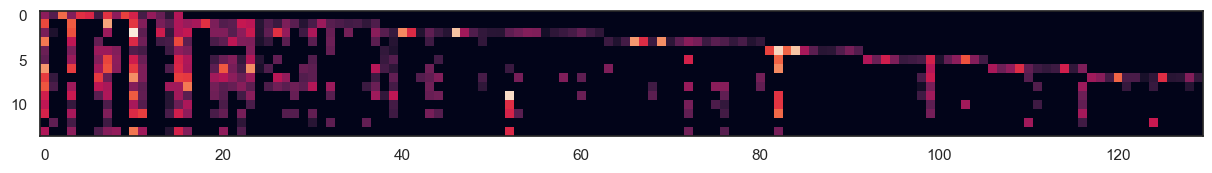

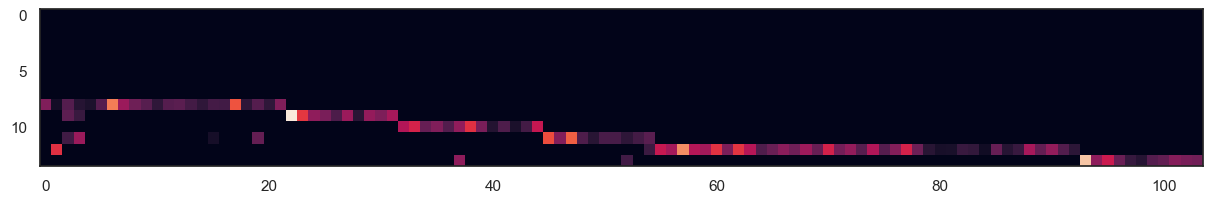

In [20]:
# tracking cells across sessions - at specific time window!
fig = plt.subplots(figsize =(15, 10))
plt.imshow(np.transpose(mean_activity_global[0:130]))
plt.show()
fig = plt.subplots(figsize =(15, 10))
plt.imshow(np.transpose(mean_activity_global[131:250]))
plt.show()

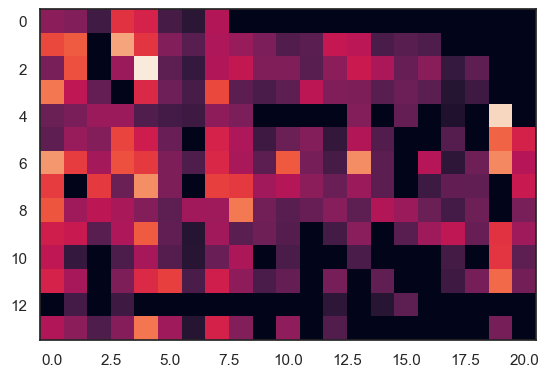

In [49]:
# (global) cells active across sessions 233 at start: 0,3,6,7,10,11,14,15,16,19,20,21,22,23,30,32,37,39,43,82,99
plt.imshow(np.transpose(mean_activity_global.iloc[[0,3,6,7,10,11,14,15,16,19,20,21,22,23,30,32,37,39,43,82,99]]))
plt.show()

# correlation matrix: session by session (STIMULUS ONSET)

Text(0.5, 1.0, '200msec before / 500msec after stimulus onset')

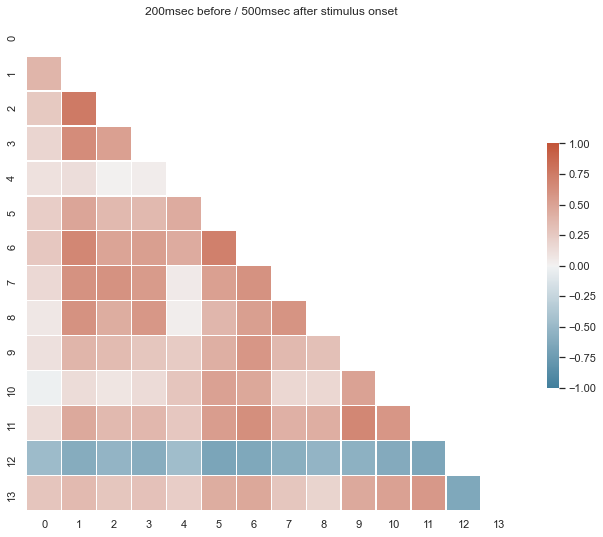

In [18]:
mean_activity_global = global_cells_sess.copy() # make copy of dataframe

# for each non-airpuff session:
for session in session_list:

    # load csv calcium traces
    folder_name = "Calcium_Traces/"
    filename = "2021-05-{0}.csv".format(session)
    df = pd.read_csv(os.path.join(animal_folder_name,folder_name, filename))
    n_rows, n_columns = df.shape

    # create time array
    df_times = df[' '][1:-1]
    df_num_time = pd.to_numeric(df_times, downcast='float')
    time_array = df_num_time.to_numpy()
    tot_timepoints = len(time_array)

    # check time sampling - i.e. if every data point is taken at the same "distance" in time from the next - or previous
    time_sampling = np.zeros(shape=(len(time_array)-1,))
    for i in range(1,len(time_array)):
        time_sampling[i-1] = time_array[i]-time_array[i-1]

    #12420 timepoints sampled at 100msec. means that every 10 of those timepoints is 1 sec
    sampling_rate = 0.1
    tot_secs = int(tot_timepoints * sampling_rate)

    # create channels array
    n_channels = n_columns-1
    channels_array = np.zeros(shape=(tot_timepoints, n_channels)) # initiate empty array
    # fill empty channels array
    for i in range(n_channels):
        col_name = df.columns[i+1]
        df_channel = df[col_name][1:-1]
        df_num_channel = pd.to_numeric(df_channel, downcast='float')
        channels_array[:,i] = df_num_channel.to_numpy()

    # load the behavioral data
    #folder_name = "trial_info" #/no_airpuff"
    #bhv_info_filename = "trial_info_2021-05-{0}.mat".format(session)
    #trial_info = scipy.io.loadmat(os.path.join(animal_folder_name,folder_name, bhv_info_filename))

    # extract information from trial_info: in matlab this is a struct with the fields:
    #trials_start_time = trial_info['trial_info'][0,0][0].ravel()
    #trials_stimulus_on = trial_info['trial_info'][0,0][1].ravel()
    #trials_response = trial_info['trial_info'][0,0][2].ravel()
    #trials_is_right_lick = trial_info['trial_info'][0,0][3].ravel()
    #trials_is_reward = trial_info['trial_info'][0,0][4].ravel()
    #trials_end_time = trial_info['trial_info'][0,0][5].ravel()
    #trials_finish_reward = trial_info['trial_info'][0,0][6].ravel()
    #n_trials = len(trials_end_time) # number of trials
    
    # load behavioural data (.pkl file)
    input_filename = "trial_info/trial_info_2021-05-{0}.pkl".format(session)
    with open(os.path.join(animal_folder_name,input_filename), 'rb') as fp:
         trial_info = pickle.load(fp)

    # extract information for trial_info: in PYTHON
    trials_start_time = np.array(trial_info['start_time'])
    trials_stimulus_on = np.array(trial_info['stimulus_on'])
    trials_response = np.array(trial_info['response'])
    trials_is_right_lick = np.array(trial_info['is_right_lick'])
    trials_is_reward = np.array(trial_info['is_reward'])
    trials_end_time = np.array(trial_info['end_trial'])
    n_trials = len(trials_end_time)

    # 500msec between start and stimulus onset
    new_start = [] # initiate empty list
    new_end = [] # initiate empty list
    new_start.append(trials_stimulus_on[0]-0.5) # append first start
    new_end.append(trials_stimulus_on[1]-0.5) # append first end
    for i in range(1,n_trials-1): # append start & end times for each trial (except last)
        new_start.append(trials_stimulus_on[i]-0.5)
        new_end.append(trials_stimulus_on[i+1]-0.5)
    new_start.append(trials_stimulus_on[n_trials-1]-0.5) # append last start
    new_end.append(trials_end_time[n_trials-1]) # append last end
    new_start = np.array(new_start) # turn list to array
    new_end = np.array(new_end)
    n_trials = len(new_end)
    
    # where was the stimulus? we don't have this info. But it can be reconstructed 
    stimulus_reconstruction = np.zeros(shape=(n_trials,))
    right_choice = np.where(trials_is_reward==1)[0]
    stimulus_reconstruction[right_choice] = trials_is_right_lick[right_choice]
    wrong_choice = np.where(trials_is_reward==0)[0]
    stimulus_reconstruction[wrong_choice] = 1 - trials_is_right_lick[wrong_choice]

    # split traces data by trials
    X = {}
    for i in range(n_trials-1):
        lower_bound = np.min(np.where(time_array>=new_start[i]))
        upper_bound = np.max(np.where(time_array<=new_end[i]))
        X[i] = channels_array[lower_bound:upper_bound,:]

    ##### mean neuron activity during time window
    cov_trials = []
    n_before_stim = 2
    n_after_stim = 5
    time_window = n_before_stim+n_after_stim
    x = []
    selected_trials = ((new_end - trials_stimulus_on)/sampling_rate > time_window)

    idx_idx = 0
    # for each trial:
    for idx in X:
        if selected_trials[idx_idx]==1:
            # stimulus timepoint
            stim_timepoint = int((trials_stimulus_on[idx_idx] - new_start[idx_idx]) /sampling_rate)
            # append traces data within time window to x
            x.append(X[idx_idx][stim_timepoint-n_before_stim:stim_timepoint+n_after_stim])
        idx_idx +=1
    x = np.mean(x, axis=0) # mean across trials
    x = np.mean(x, axis=0) # mean of each neuron in this time window
    
    session_int = int(session) # session as integer (instead of string)
    cur_sess = no_apf_sessions.index(session_int) # current session
    
    # get all local cell indeces for current session and sort in ascending order
    order_loccells = global_cells[global_cells['local_cellset_index']==cur_sess]['local_cell_index'].values.tolist()
    order_loccells.sort()
    
    # map local to global cell index in non-airpuff sessions
    # for each local cell in current session:
    for cell in order_loccells:
        # find local cell index in dataframe
        idx = np.where(mean_activity_global[:][cur_sess]==cell)[0][0]
        # replace index with cell activity
        mean_activity_global.loc[idx, cur_sess] = x[order_loccells.index(cell)] # replace cell number with mean activity

   
        
# for each airpuff session:
for session in range(14,20): 

    # LOAD CSV CALCIUM TRACES
    folder_name = "Calcium_Traces/"
    filename = "2021-05-{0}.csv".format(session)
    df = pd.read_csv(os.path.join(animal_folder_name,folder_name, filename))
    n_rows, n_columns = df.shape

    # create time array
    df_times = df[' '][1:-1]
    df_num_time = pd.to_numeric(df_times, downcast='float')
    time_array = df_num_time.to_numpy()
    tot_timepoints = len(time_array)

    # check time sampling - i.e. if every data point is taken at the same "distance" in time from the next - or previous
    time_sampling = np.zeros(shape=(len(time_array)-1,))

    #12420 timepoints sampled at 100msec. means that every 10 of those timepoints is 1 sec
    sampling_rate = 0.1
    tot_secs = int(tot_timepoints * sampling_rate)

    # create channels array
    n_channels = n_columns-1
    channels_array = np.zeros(shape=(tot_timepoints, n_channels)) # initiate empty array
    # fill empty channels array
    for i in range(n_channels):
        col_name = df.columns[i+1]
        df_channel = df[col_name][1:-1]
        df_num_channel = pd.to_numeric(df_channel, downcast='float')
        channels_array[:,i] = df_num_channel.to_numpy()

    # LOAD BEHAVIOURAL DATA
    #folder_name = "trial_info"
    #bhv_info_filename = "trial_info_2021-05-{0}.mat".format(session)
    #trial_info = scipy.io.loadmat(os.path.join(animal_folder_name,folder_name, bhv_info_filename))

    # extract information from trial_info: in matlab this is a struct with the fields:
    #trials_start_time = trial_info['trial_info'][0,0][0].ravel()
    #trials_stimulus_on = trial_info['trial_info'][0,0][1].ravel()
    #trials_response = trial_info['trial_info'][0,0][2].ravel()
    #trials_is_right_lick = trial_info['trial_info'][0,0][3].ravel()
    #trials_is_reward = trial_info['trial_info'][0,0][4].ravel()
    #trials_end_time = trial_info['trial_info'][0,0][5].ravel()
    #n_trials = len(trials_end_time) # number of trials
    
    # load behavioural data (.pkl file)
    input_filename = "trial_info/trial_info_2021-05-{0}.pkl".format(session)
    with open(os.path.join(animal_folder_name,input_filename), 'rb') as fp:
         trial_info = pickle.load(fp)

    # extract information for trial_info: in PYTHON
    trials_start_time = np.array(trial_info['start_time'])
    trials_stimulus_on = np.array(trial_info['stimulus_on'])
    trials_response = np.array(trial_info['response'])
    trials_is_right_lick = np.array(trial_info['is_right_lick'])
    trials_is_reward = np.array(trial_info['is_reward'])
    trials_end_time = np.array(trial_info['end_trial'])
    n_trials = len(trials_end_time)

    # 500msec between start and stimulus onset
    new_start = [] # initiate empty list
    new_end = [] # initiate empty list
    new_start.append(trials_stimulus_on[0]-0.5) # append first start
    new_end.append(trials_stimulus_on[1]-0.5) # append first end
    for i in range(1,n_trials-1): # append start & end times for each trial (except last)
        new_start.append(trials_stimulus_on[i]-0.5)
        new_end.append(trials_stimulus_on[i+1]-0.5)
    new_start.append(trials_stimulus_on[n_trials-1]-0.5) # append last start
    new_end.append(trials_end_time[n_trials-1]) # append last end
    new_start = np.array(new_start) # turn list to array
    new_end = np.array(new_end)
    n_trials = len(new_end)
    
    # where was the stimulus? we don't have this info. But it can be reconstructed 
    stimulus_reconstruction = np.zeros(shape=(n_trials,))
    right_choice = np.where(trials_is_reward==1)[0]
    stimulus_reconstruction[right_choice] = trials_is_right_lick[right_choice]
    wrong_choice = np.where(trials_is_reward==0)[0]
    stimulus_reconstruction[wrong_choice] = 1 - trials_is_right_lick[wrong_choice]

    # split traces data by trials
    X = {}
    for i in range(n_trials-1):
        lower_bound = np.min(np.where(time_array>=new_start[i]))
        upper_bound = np.max(np.where(time_array<=new_end[i]))
        X[i] = channels_array[lower_bound:upper_bound,:]
        
        
    ##### mean neuron activity during time window
    cov_trials = []
    n_before_stim = 2
    n_after_stim = 5
    time_window = n_before_stim+n_after_stim
    x = []
    selected_trials = ((new_end - trials_stimulus_on)/sampling_rate > time_window)

    idx_idx = 0
    # for each trial:
    for idx in X:
        if selected_trials[idx_idx]==1:
            # stimulus timepoint
            stim_timepoint = int((trials_stimulus_on[idx_idx] - new_start[idx_idx]) /sampling_rate)   
            # append traces data within time window to x
            x.append(X[idx_idx][stim_timepoint-n_before_stim:stim_timepoint+n_after_stim])
        idx_idx +=1
    x = np.mean(x, axis=0) # mean across trials
    x = np.mean(x, axis=0) # mean of each neuron in this time window
        
    # get all local cell indeces for current session and sort in ascending order
    order_loccells = global_cells[global_cells['local_cellset_index']==session-6]['local_cell_index'].values.tolist()
    order_loccells.sort()
    
    # map local to global cell index in airpuff sessions
    # for each local cell in current session:
    for cell in order_loccells:
        # find local cell index in dataframe
        idx = np.where(mean_activity_global[:][session-6]==cell)[0][0]
        # replace index with cell activity
        mean_activity_global.loc[idx, session-6] = x[order_loccells.index(cell)] # replace cell number with mean activity
        
# NaN means no activity = 0
mean_activity_global = mean_activity_global.fillna(0)
        
# correlation matrix session by session
cov = np.cov(mean_activity_global, rowvar=False)
    
### plot correlation matrix of channels
sns.set_theme(style="white")
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(pd.DataFrame(cov).corr(), dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(pd.DataFrame(cov).corr(), mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=-1, vmax=1)
ax.set_title('200msec before / 500msec after stimulus onset')

# correlation matrix: session by session (RESPONSE)

Text(0.5, 1.0, '500msec before / 200msec after response')

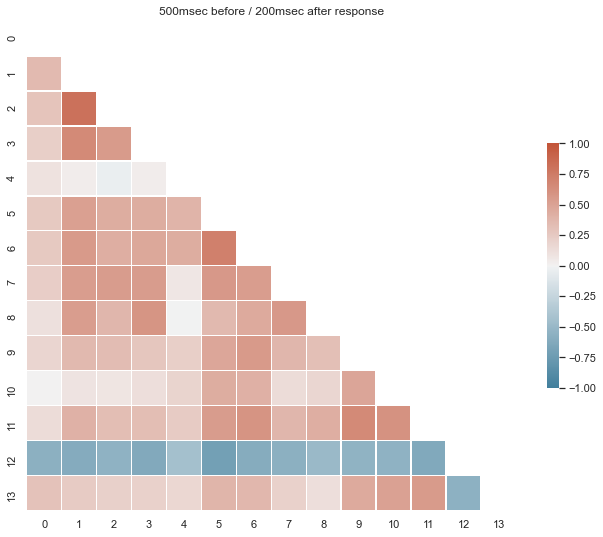

In [19]:
mean_activity_global = global_cells_sess.copy() # make copy of dataframe

# for each non-airpuff session
for session in session_list:

    # load csv calcium traces
    folder_name = "Calcium_Traces/"
    filename = "2021-05-{0}.csv".format(session)
    df = pd.read_csv(os.path.join(animal_folder_name,folder_name, filename))
    n_rows, n_columns = df.shape

    # create time array
    df_times = df[' '][1:-1]
    df_num_time = pd.to_numeric(df_times, downcast='float')
    time_array = df_num_time.to_numpy()
    tot_timepoints = len(time_array)

    # check time sampling - i.e. if every data point is taken at the same "distance" in time from the next - or previous
    time_sampling = np.zeros(shape=(len(time_array)-1,))
    for i in range(1,len(time_array)):
        time_sampling[i-1] = time_array[i]-time_array[i-1]

    #12420 timepoints sampled at 100msec. means that every 10 of those timepoints is 1 sec
    sampling_rate = 0.1
    tot_secs = int(tot_timepoints * sampling_rate)

    # create channels array
    n_channels = n_columns-1
    channels_array = np.zeros(shape=(tot_timepoints, n_channels)) # initiate empty array
    # fill empty channels array
    for i in range(n_channels):
        col_name = df.columns[i+1]
        df_channel = df[col_name][1:-1]
        df_num_channel = pd.to_numeric(df_channel, downcast='float')
        channels_array[:,i] = df_num_channel.to_numpy()

    # load the behavioral data
    #folder_name = "trial_info" #/no_airpuff"
    #bhv_info_filename = "trial_info_2021-05-{0}.mat".format(session)
    #trial_info = scipy.io.loadmat(os.path.join(animal_folder_name,folder_name, bhv_info_filename))

    # extract information from trial_info: in matlab this is a struct with the fields:
    #trials_start_time = trial_info['trial_info'][0,0][0].ravel()
    #trials_stimulus_on = trial_info['trial_info'][0,0][1].ravel()
    #trials_response = trial_info['trial_info'][0,0][2].ravel()
    #trials_is_right_lick = trial_info['trial_info'][0,0][3].ravel()
    #trials_is_reward = trial_info['trial_info'][0,0][4].ravel()
    #trials_end_time = trial_info['trial_info'][0,0][5].ravel()
    #trials_finish_reward = trial_info['trial_info'][0,0][6].ravel()
    #n_trials = len(trials_end_time) # number of trials
    
    # load behavioural data (.pkl file)
    input_filename = "trial_info/trial_info_2021-05-{0}.pkl".format(session)
    with open(os.path.join(animal_folder_name,input_filename), 'rb') as fp:
         trial_info = pickle.load(fp)

    # extract information for trial_info: in PYTHON
    trials_start_time = np.array(trial_info['start_time'])
    trials_stimulus_on = np.array(trial_info['stimulus_on'])
    trials_response = np.array(trial_info['response'])
    trials_is_right_lick = np.array(trial_info['is_right_lick'])
    trials_is_reward = np.array(trial_info['is_reward'])
    trials_end_time = np.array(trial_info['end_trial'])
    n_trials = len(trials_end_time)

    # 500msec between start and stimulus onset
    new_start = [] # initiate empty list
    new_end = [] # initiate empty list
    new_start.append(trials_stimulus_on[0]-0.5) # append first start
    new_end.append(trials_stimulus_on[1]-0.5) # append first end
    for i in range(1,n_trials-1): # append start & end times for each trial (except last)
        new_start.append(trials_stimulus_on[i]-0.5)
        new_end.append(trials_stimulus_on[i+1]-0.5)
    new_start.append(trials_stimulus_on[n_trials-1]-0.5) # append last start
    new_end.append(trials_end_time[n_trials-1]) # append last end
    new_start = np.array(new_start) # turn list to array
    new_end = np.array(new_end)
    n_trials = len(new_end)
    
    # where was the stimulus? we don't have this info. But it can be reconstructed 
    stimulus_reconstruction = np.zeros(shape=(n_trials,))
    right_choice = np.where(trials_is_reward==1)[0]
    stimulus_reconstruction[right_choice] = trials_is_right_lick[right_choice]
    wrong_choice = np.where(trials_is_reward==0)[0]
    stimulus_reconstruction[wrong_choice] = 1 - trials_is_right_lick[wrong_choice]

    # split traces data by trials
    X = {}
    for i in range(n_trials-1):
        lower_bound = np.min(np.where(time_array>=new_start[i]))
        upper_bound = np.max(np.where(time_array<=new_end[i]))
        X[i] = channels_array[lower_bound:upper_bound,:]

    ##### mean neuron activity during time window
    cov_trials = []
    n_before_resp = 5
    n_after_resp = 2
    time_window = n_before_resp+n_after_resp
    x = []
    selected_trials = ((trials_response - new_start)/sampling_rate > 7)

    idx_idx = 0
    # for each trial
    for idx in X:
        if selected_trials[idx_idx]==1:
            # response timepoint
            resp_timepoint = int((trials_response[idx_idx] - new_start[idx_idx]) / sampling_rate)
            # append traces data within time window to x
            x.append(X[idx_idx][resp_timepoint-n_before_resp:resp_timepoint+n_after_resp])
        idx_idx +=1
    x = np.mean(x, axis=0) # mean across trials
    x = np.mean(x, axis=0) # mean across time points in window (for each neuron)
    
    session_int = int(session) # session as integer (instead of string)
    cur_sess = no_apf_sessions.index(session_int) # current session
    
    # get all local cell indeces for current session and sort in ascending order
    order_loccells = global_cells[global_cells['local_cellset_index']==cur_sess]['local_cell_index'].values.tolist()
    order_loccells.sort()
    
    # map local to global cell index in non-airpuff sessions
    # for each local cell in current session:
    for cell in order_loccells:
        # find local cell index in dataframe
        idx = np.where(mean_activity_global[:][cur_sess]==cell)[0][0]
        # replace index with cell activity
        mean_activity_global.loc[idx, cur_sess] = x[order_loccells.index(cell)] # replace cell number with mean activity

  
        
# for each airpuff session:
for session in range(14,20): 

    # LOAD CSV CALCIUM TRACES
    folder_name = "Calcium_Traces/"
    filename = "2021-05-{0}.csv".format(session)
    df = pd.read_csv(os.path.join(animal_folder_name,folder_name, filename))
    n_rows, n_columns = df.shape

    # create time array
    df_times = df[' '][1:-1]
    df_num_time = pd.to_numeric(df_times, downcast='float')
    time_array = df_num_time.to_numpy()
    tot_timepoints = len(time_array)

    # check time sampling - i.e. if every data point is taken at the same "distance" in time from the next - or previous
    time_sampling = np.zeros(shape=(len(time_array)-1,))

    #12420 timepoints sampled at 100msec. means that every 10 of those timepoints is 1 sec
    sampling_rate = 0.1
    tot_secs = int(tot_timepoints * sampling_rate)

    # create channels array
    n_channels = n_columns-1
    channels_array = np.zeros(shape=(tot_timepoints, n_channels)) # initiate empty array
    # fill empty channels array
    for i in range(n_channels):
        col_name = df.columns[i+1]
        df_channel = df[col_name][1:-1]
        df_num_channel = pd.to_numeric(df_channel, downcast='float')
        channels_array[:,i] = df_num_channel.to_numpy()

    # LOAD BEHAVIOURAL DATA
    #folder_name = "trial_info"
    #bhv_info_filename = "trial_info_2021-05-{0}.mat".format(session)
    #trial_info = scipy.io.loadmat(os.path.join(animal_folder_name,folder_name, bhv_info_filename))

    # extract information from trial_info: in matlab this is a struct with the fields:
    #trials_start_time = trial_info['trial_info'][0,0][0].ravel()
    #trials_stimulus_on = trial_info['trial_info'][0,0][1].ravel()
    #trials_response = trial_info['trial_info'][0,0][2].ravel()
    #trials_is_right_lick = trial_info['trial_info'][0,0][3].ravel()
    #trials_is_reward = trial_info['trial_info'][0,0][4].ravel()
    #trials_end_time = trial_info['trial_info'][0,0][5].ravel()
    #n_trials = len(trials_end_time) # number of trials
    
    # load behavioural data (.pkl file)
    input_filename = "trial_info/trial_info_2021-05-{0}.pkl".format(session)
    with open(os.path.join(animal_folder_name,input_filename), 'rb') as fp:
         trial_info = pickle.load(fp)

    # extract information for trial_info: in PYTHON
    trials_start_time = np.array(trial_info['start_time'])
    trials_stimulus_on = np.array(trial_info['stimulus_on'])
    trials_response = np.array(trial_info['response'])
    trials_is_right_lick = np.array(trial_info['is_right_lick'])
    trials_is_reward = np.array(trial_info['is_reward'])
    trials_end_time = np.array(trial_info['end_trial'])
    n_trials = len(trials_end_time)

    # 500msec between start and stimulus onset
    new_start = [] # initiate empty list
    new_end = [] # initiate empty list
    new_start.append(trials_stimulus_on[0]-0.5) # append first start
    new_end.append(trials_stimulus_on[1]-0.5) # append first end
    for i in range(1,n_trials-1): # append start & end times for each trial (except last)
        new_start.append(trials_stimulus_on[i]-0.5)
        new_end.append(trials_stimulus_on[i+1]-0.5)
    new_start.append(trials_stimulus_on[n_trials-1]-0.5) # append last start
    new_end.append(trials_end_time[n_trials-1]) # append last end
    new_start = np.array(new_start) # turn list to array
    new_end = np.array(new_end)
    n_trials = len(new_end)
    
    # where was the stimulus? we don't have this info. But it can be reconstructed 
    stimulus_reconstruction = np.zeros(shape=(n_trials,))
    right_choice = np.where(trials_is_reward==1)[0]
    stimulus_reconstruction[right_choice] = trials_is_right_lick[right_choice]
    wrong_choice = np.where(trials_is_reward==0)[0]
    stimulus_reconstruction[wrong_choice] = 1 - trials_is_right_lick[wrong_choice]

    # split traces data by trials
    X = {}
    for i in range(n_trials-1):
        lower_bound = np.min(np.where(time_array>=new_start[i]))
        upper_bound = np.max(np.where(time_array<=new_end[i]))
        X[i] = channels_array[lower_bound:upper_bound,:]
        
        
    ##### mean neuron activity during time window
    cov_trials = []
    n_before_resp = 5
    n_after_resp = 2
    time_window = n_before_resp+n_after_resp
    x = []
    selected_trials = ((trials_response - new_start)/sampling_rate > 7)

    idx_idx = 0
    # for each trial:
    for idx in X:
        if selected_trials[idx_idx]==1:
            # response timepoint
            resp_timepoint = int((trials_response[idx_idx] - new_start[idx_idx]) / sampling_rate)
            # append traces data within time window to x
            x.append(X[idx_idx][resp_timepoint-n_before_resp:resp_timepoint+n_after_resp])
        idx_idx +=1
    x = np.mean(x, axis=0) # mean across trials
    x = np.mean(x, axis=0) # mean of each neuron in this time window
        
    # get all local cell indeces for current session and sort in ascending order
    order_loccells = global_cells[global_cells['local_cellset_index']==session-6]['local_cell_index'].values.tolist()
    order_loccells.sort()
    
    # map local to global cell index in airpuff sessions
    # for each local cell in current session:
    for cell in order_loccells:
        # find local cell index in dataframe
        idx = np.where(mean_activity_global[:][session-6]==cell)[0][0]
        # replace index with cell activity
        mean_activity_global.loc[idx, session-6] = x[order_loccells.index(cell)] # replace cell number with mean activity
        
# NaN means no activity = 0
mean_activity_global = mean_activity_global.fillna(0)
        
# correlation matrix session by session
cov = np.cov(mean_activity_global, rowvar=False)
    
### plot correlation matrix of channels
sns.set_theme(style="white")
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(pd.DataFrame(cov).corr(), dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(pd.DataFrame(cov).corr(), mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=-1, vmax=1)
ax.set_title('500msec before / 200msec after response')

# correlation matrix: session by session (PUNISHMENT)

Text(0.5, 1.0, '200msec before / 500msec after punishment')

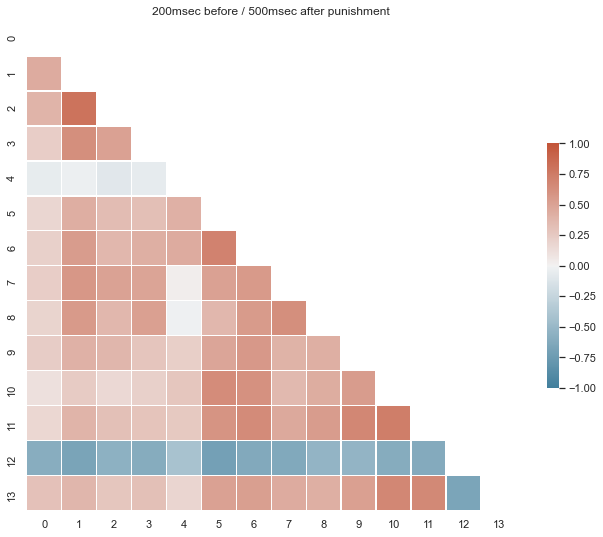

In [20]:
mean_activity_global = global_cells_sess.copy() # make copy of dataframe

# for each non-airpuff session:
for session in session_list:

    # load csv calcium traces
    folder_name = "Calcium_Traces/"
    filename = "2021-05-{0}.csv".format(session)
    df = pd.read_csv(os.path.join(animal_folder_name,folder_name, filename))
    n_rows, n_columns = df.shape

    # create time array
    df_times = df[' '][1:-1]
    df_num_time = pd.to_numeric(df_times, downcast='float')
    time_array = df_num_time.to_numpy()
    tot_timepoints = len(time_array)

    # check time sampling - i.e. if every data point is taken at the same "distance" in time from the next - or previous
    time_sampling = np.zeros(shape=(len(time_array)-1,))
    for i in range(1,len(time_array)):
        time_sampling[i-1] = time_array[i]-time_array[i-1]

    #12420 timepoints sampled at 100msec. means that every 10 of those timepoints is 1 sec
    sampling_rate = 0.1
    tot_secs = int(tot_timepoints * sampling_rate)

    # create channels array
    n_channels = n_columns-1
    channels_array = np.zeros(shape=(tot_timepoints, n_channels)) # initiate empty array
    # fill empty channels array
    for i in range(n_channels):
        col_name = df.columns[i+1]
        df_channel = df[col_name][1:-1]
        df_num_channel = pd.to_numeric(df_channel, downcast='float')
        channels_array[:,i] = df_num_channel.to_numpy()

    # load the behavioral data
    #folder_name = "trial_info"
    #bhv_info_filename = "trial_info_2021-05-{0}.mat".format(session)
    #trial_info = scipy.io.loadmat(os.path.join(animal_folder_name,folder_name, bhv_info_filename))

    # extract information from trial_info: in matlab this is a struct with the fields:
    #trials_start_time = trial_info['trial_info'][0,0][0].ravel()
    #trials_stimulus_on = trial_info['trial_info'][0,0][1].ravel()
    #trials_response = trial_info['trial_info'][0,0][2].ravel()
    #trials_is_right_lick = trial_info['trial_info'][0,0][3].ravel()
    #trials_is_reward = trial_info['trial_info'][0,0][4].ravel()
    #trials_end_time = trial_info['trial_info'][0,0][5].ravel()
    #trials_finish_reward = trial_info['trial_info'][0,0][6].ravel()
    #n_trials = len(trials_end_time) # number of trials
    
    # load behavioural data (.pkl file)
    input_filename = "trial_info/trial_info_2021-05-{0}.pkl".format(session)
    with open(os.path.join(animal_folder_name,input_filename), 'rb') as fp:
         trial_info = pickle.load(fp)

    # extract information for trial_info: in PYTHON
    trials_start_time = np.array(trial_info['start_time'])
    trials_stimulus_on = np.array(trial_info['stimulus_on'])
    trials_response = np.array(trial_info['response'])
    trials_is_right_lick = np.array(trial_info['is_right_lick'])
    trials_is_reward = np.array(trial_info['is_reward'])
    trials_end_time = np.array(trial_info['end_trial'])
    n_trials = len(trials_end_time)

    # 500msec between start and stimulus onset
    new_start = [] # initiate empty list
    new_end = [] # initiate empty list
    new_start.append(trials_stimulus_on[0]-0.5) # append first start
    new_end.append(trials_stimulus_on[1]-0.5) # append first end
    for i in range(1,n_trials-1): # append start & end times for each trial (except last)
        new_start.append(trials_stimulus_on[i]-0.5)
        new_end.append(trials_stimulus_on[i+1]-0.5)
    new_start.append(trials_stimulus_on[n_trials-1]-0.5) # append last start
    new_end.append(trials_end_time[n_trials-1]) # append last end
    new_start = np.array(new_start) # turn list to array
    new_end = np.array(new_end)
    n_trials = len(new_end)
    
    # where was the stimulus? we don't have this info. But it can be reconstructed 
    stimulus_reconstruction = np.zeros(shape=(n_trials,))
    right_choice = np.where(trials_is_reward==1)[0]
    stimulus_reconstruction[right_choice] = trials_is_right_lick[right_choice]
    wrong_choice = np.where(trials_is_reward==0)[0]
    stimulus_reconstruction[wrong_choice] = 1 - trials_is_right_lick[wrong_choice]

    # split traces data by trials
    X = {}
    for i in range(n_trials-1):
        lower_bound = np.min(np.where(time_array>=new_start[i]))
        upper_bound = np.max(np.where(time_array<=new_end[i]))
        X[i] = channels_array[lower_bound:upper_bound,:]

    ##### mean neuron activity during time window
    cov_trials = []
    n_before_pun = 2
    n_after_pun = 5
    time_window = n_before_pun + n_after_pun
    x = []
    selected_trials = ((new_end - trials_response)/sampling_rate > 7)

    idx_idx = 0
    # for each trial
    for idx in X:
        if selected_trials[idx_idx]==1:
            if trials_is_reward[idx_idx]==0:
                # response timepoint
                resp_timepoint = int((trials_response[idx_idx] - new_start[idx_idx]) / sampling_rate)
                # append traces data within time window to x
                x.append(X[idx_idx][resp_timepoint-n_before_pun:resp_timepoint+n_after_pun])
        idx_idx +=1
    x = np.mean(x, axis=0) # mean across trials
    x = np.mean(x, axis=0) # mean across time points in window (for each neuron)
    
    session_int = int(session) # session as integer (instead of string)
    cur_sess = no_apf_sessions.index(session_int) # current session
    
    # get all local cell indeces for current session and sort in ascending order
    order_loccells = global_cells[global_cells['local_cellset_index']==cur_sess]['local_cell_index'].values.tolist()
    order_loccells.sort()
    
    # map local to global cell index in non-airpuff sessions
    # for each local cell in current session:
    for cell in order_loccells:
        # find local cell index in dataframe
        idx = np.where(mean_activity_global[:][cur_sess]==cell)[0][0]
        # replace index with cell activity
        mean_activity_global.loc[idx, cur_sess] = x[order_loccells.index(cell)] # replace cell number with mean activity


        
# for each airpuff session:
for session in range(14,20):

    # LOAD CSV CALCIUM TRACES
    folder_name = "Calcium_Traces/"
    filename = "2021-05-{0}.csv".format(session)
    df = pd.read_csv(os.path.join(animal_folder_name,folder_name, filename))
    n_rows, n_columns = df.shape

    # create time array
    df_times = df[' '][1:-1]
    df_num_time = pd.to_numeric(df_times, downcast='float')
    time_array = df_num_time.to_numpy()
    tot_timepoints = len(time_array)

    # check time sampling - i.e. if every data point is taken at the same "distance" in time from the next - or previous
    time_sampling = np.zeros(shape=(len(time_array)-1,))

    #12420 timepoints sampled at 100msec. means that every 10 of those timepoints is 1 sec
    sampling_rate = 0.1
    tot_secs = int(tot_timepoints * sampling_rate)

    # create channels array
    n_channels = n_columns-1
    channels_array = np.zeros(shape=(tot_timepoints, n_channels)) # initiate empty array
    # fill empty channels array
    for i in range(n_channels):
        col_name = df.columns[i+1]
        df_channel = df[col_name][1:-1]
        df_num_channel = pd.to_numeric(df_channel, downcast='float')
        channels_array[:,i] = df_num_channel.to_numpy()

    # LOAD BEHAVIOURAL DATA
    #folder_name = "trial_info"
    #bhv_info_filename = "trial_info_2021-05-{0}.mat".format(session)
    #trial_info = scipy.io.loadmat(os.path.join(animal_folder_name,folder_name, bhv_info_filename))

    # extract information from trial_info: in matlab this is a struct with the fields:
    #trials_start_time = trial_info['trial_info'][0,0][0].ravel()
    #trials_stimulus_on = trial_info['trial_info'][0,0][1].ravel()
    #trials_response = trial_info['trial_info'][0,0][2].ravel()
    #trials_is_right_lick = trial_info['trial_info'][0,0][3].ravel()
    #trials_is_reward = trial_info['trial_info'][0,0][4].ravel()
    #trials_end_time = trial_info['trial_info'][0,0][5].ravel()
    #n_trials = len(trials_end_time) # number of trials
    
    # load behavioural data (.pkl file)
    input_filename = "trial_info/trial_info_2021-05-{0}.pkl".format(session)
    with open(os.path.join(animal_folder_name,input_filename), 'rb') as fp:
         trial_info = pickle.load(fp)

    # extract information for trial_info: in PYTHON
    trials_start_time = np.array(trial_info['start_time'])
    trials_stimulus_on = np.array(trial_info['stimulus_on'])
    trials_response = np.array(trial_info['response'])
    trials_is_right_lick = np.array(trial_info['is_right_lick'])
    trials_is_reward = np.array(trial_info['is_reward'])
    trials_end_time = np.array(trial_info['end_trial'])
    n_trials = len(trials_end_time)

    # 500msec between start and stimulus onset
    new_start = [] # initiate empty list
    new_end = [] # initiate empty list
    new_start.append(trials_stimulus_on[0]-0.5) # append first start
    new_end.append(trials_stimulus_on[1]-0.5) # append first end
    for i in range(1,n_trials-1): # append start & end times for each trial (except last)
        new_start.append(trials_stimulus_on[i]-0.5)
        new_end.append(trials_stimulus_on[i+1]-0.5)
    new_start.append(trials_stimulus_on[n_trials-1]-0.5) # append last start
    new_end.append(trials_end_time[n_trials-1]) # append last end
    new_start = np.array(new_start) # turn list to array
    new_end = np.array(new_end)
    n_trials = len(new_end)
    
    # where was the stimulus? we don't have this info. But it can be reconstructed 
    stimulus_reconstruction = np.zeros(shape=(n_trials,))
    right_choice = np.where(trials_is_reward==1)[0]
    stimulus_reconstruction[right_choice] = trials_is_right_lick[right_choice]
    wrong_choice = np.where(trials_is_reward==0)[0]
    stimulus_reconstruction[wrong_choice] = 1 - trials_is_right_lick[wrong_choice]

    # split traces data by trials
    X = {}
    for i in range(n_trials-1):
        lower_bound = np.min(np.where(time_array>=new_start[i]))
        upper_bound = np.max(np.where(time_array<=new_end[i]))
        X[i] = channels_array[lower_bound:upper_bound,:]
        
        
    ##### mean neuron activity during time window
    cov_trials = []
    n_before_pun = 2
    n_after_pun = 5
    time_window = n_before_pun + n_after_pun
    airpuff = 2
    x = []
    selected_trials = ((new_end - trials_response)/sampling_rate > 7)

    idx_idx = 0
    # for each trial:
    for idx in X:
        if selected_trials[idx_idx]==1:
            if trials_is_reward[idx_idx]==0:
                # response timepoint
                resp_timepoint = int((trials_response[idx_idx] - new_start[idx_idx]) / sampling_rate)+airpuff
                # append traces data within time window to x
                x.append(X[idx_idx][resp_timepoint-n_before_pun:resp_timepoint+n_after_pun])
        idx_idx +=1
    x = np.mean(x, axis=0) # mean across trials
    x = np.mean(x, axis=0) # mean across time points in window (for each neuron)
        
    # get all local cell indeces for current session and sort in ascending order
    order_loccells = global_cells[global_cells['local_cellset_index']==session-6]['local_cell_index'].values.tolist()
    order_loccells.sort()
    
    # map local to global cell index in airpuff sessions
    # for each local cell in current session:
    for cell in order_loccells:
        # find local cell index in dataframe
        idx = np.where(mean_activity_global[:][session-6]==cell)[0][0]
        # replace index with cell activity
        mean_activity_global.loc[idx, session-6] = x[order_loccells.index(cell)] # replace cell number with mean activity

# NaN means no activity = 0
mean_activity_global = mean_activity_global.fillna(0)
        
# correlation matrix session by session
cov = np.cov(mean_activity_global, rowvar=False)
    
### plot correlation matrix of channels
sns.set_theme(style="white")
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(pd.DataFrame(cov).corr(), dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(pd.DataFrame(cov).corr(), mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=-1, vmax=1)
ax.set_title('200msec before / 500msec after punishment')

# correlation matrix: session by session (REWARD)

Text(0.5, 1.0, '200msec before / 500msec after reward')

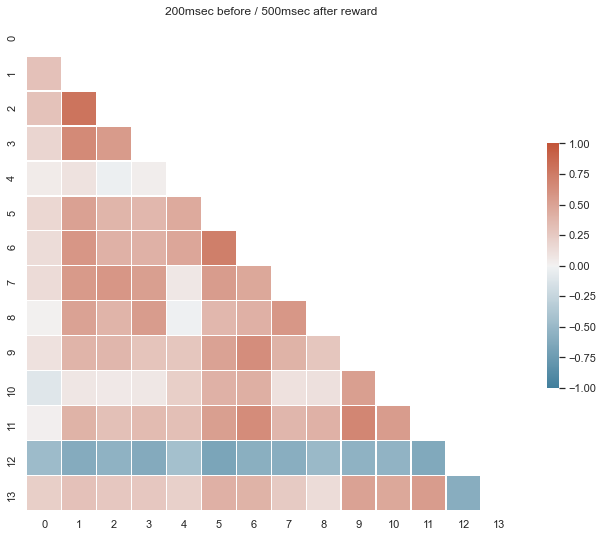

In [21]:
mean_activity_global = global_cells_sess.copy() # make copy of dataframe

# for each non-airpuff session:
for session in session_list: 

    # load csv calcium traces
    folder_name = "Calcium_Traces/"
    filename = "2021-05-{0}.csv".format(session)
    df = pd.read_csv(os.path.join(animal_folder_name,folder_name, filename))
    n_rows, n_columns = df.shape

    # create time array
    df_times = df[' '][1:-1]
    df_num_time = pd.to_numeric(df_times, downcast='float')
    time_array = df_num_time.to_numpy()
    tot_timepoints = len(time_array)

    # check time sampling - i.e. if every data point is taken at the same "distance" in time from the next - or previous
    time_sampling = np.zeros(shape=(len(time_array)-1,))
    for i in range(1,len(time_array)):
        time_sampling[i-1] = time_array[i]-time_array[i-1]

    #12420 timepoints sampled at 100msec. means that every 10 of those timepoints is 1 sec
    sampling_rate = 0.1
    tot_secs = int(tot_timepoints * sampling_rate)

    # create channels array
    n_channels = n_columns-1
    channels_array = np.zeros(shape=(tot_timepoints, n_channels)) # initiate empty array
    # fill empty channels array
    for i in range(n_channels):
        col_name = df.columns[i+1]
        df_channel = df[col_name][1:-1]
        df_num_channel = pd.to_numeric(df_channel, downcast='float')
        channels_array[:,i] = df_num_channel.to_numpy()

    # load the behavioral data
    #folder_name = "trial_info"
    #bhv_info_filename = "trial_info_2021-05-{0}.mat".format(session)
    #trial_info = scipy.io.loadmat(os.path.join(animal_folder_name,folder_name, bhv_info_filename))

    # extract information from trial_info: in matlab this is a struct with the fields:
    #trials_start_time = trial_info['trial_info'][0,0][0].ravel()
    #trials_stimulus_on = trial_info['trial_info'][0,0][1].ravel()
    #trials_response = trial_info['trial_info'][0,0][2].ravel()
    #trials_is_right_lick = trial_info['trial_info'][0,0][3].ravel()
    #trials_is_reward = trial_info['trial_info'][0,0][4].ravel()
    #trials_end_time = trial_info['trial_info'][0,0][5].ravel()
    #trials_finish_reward = trial_info['trial_info'][0,0][6].ravel()
    #n_trials = len(trials_end_time) # number of trials
    
    # load behavioural data (.pkl file)
    input_filename = "trial_info/trial_info_2021-05-{0}.pkl".format(session)
    with open(os.path.join(animal_folder_name,input_filename), 'rb') as fp:
         trial_info = pickle.load(fp)

    # extract information for trial_info: in PYTHON
    trials_start_time = np.array(trial_info['start_time'])
    trials_stimulus_on = np.array(trial_info['stimulus_on'])
    trials_response = np.array(trial_info['response'])
    trials_is_right_lick = np.array(trial_info['is_right_lick'])
    trials_is_reward = np.array(trial_info['is_reward'])
    trials_end_time = np.array(trial_info['end_trial'])
    n_trials = len(trials_end_time)

    # 500msec between start and stimulus onset
    new_start = [] # initiate empty list
    new_end = [] # initiate empty list
    new_start.append(trials_stimulus_on[0]-0.5) # append first start
    new_end.append(trials_stimulus_on[1]-0.5) # append first end
    for i in range(1,n_trials-1): # append start & end times for each trial (except last)
        new_start.append(trials_stimulus_on[i]-0.5)
        new_end.append(trials_stimulus_on[i+1]-0.5)
    new_start.append(trials_stimulus_on[n_trials-1]-0.5) # append last start
    new_end.append(trials_end_time[n_trials-1]) # append last end
    new_start = np.array(new_start) # turn list to array
    new_end = np.array(new_end)
    n_trials = len(new_end)
    
    # where was the stimulus? we don't have this info. But it can be reconstructed 
    stimulus_reconstruction = np.zeros(shape=(n_trials,))
    right_choice = np.where(trials_is_reward==1)[0]
    stimulus_reconstruction[right_choice] = trials_is_right_lick[right_choice]
    wrong_choice = np.where(trials_is_reward==0)[0]
    stimulus_reconstruction[wrong_choice] = 1 - trials_is_right_lick[wrong_choice]

    # split traces data by trials
    X = {}
    for i in range(n_trials-1):
        lower_bound = np.min(np.where(time_array>=new_start[i]))
        upper_bound = np.max(np.where(time_array<=new_end[i]))
        X[i] = channels_array[lower_bound:upper_bound,:]

    ##### mean neuron activity during time window
    cov_trials = []
    n_before_rew = 2
    n_after_rew = 5
    time_window = n_before_rew + n_after_rew
    x = []
    selected_trials = ((new_end - trials_response)/sampling_rate > 7)

    idx_idx = 0
    # for each trial
    for idx in X:
        if selected_trials[idx_idx]==1:
            if trials_is_reward[idx_idx]==1:
                # response timepoint
                resp_timepoint = int((trials_response[idx_idx] - new_start[idx_idx]) / sampling_rate)
                # append traces data within time window to x
                x.append(X[idx_idx][resp_timepoint-n_before_rew:resp_timepoint+n_after_rew])
        idx_idx +=1
    x = np.mean(x, axis=0) # mean across trials
    x = np.mean(x, axis=0) # mean across time points in window (for each neuron)
    
    session_int = int(session) # session as integer (instead of string)
    cur_sess = no_apf_sessions.index(session_int) # current session
    
    # get all local cell indeces for current session and sort in ascending order
    order_loccells = global_cells[global_cells['local_cellset_index']==cur_sess]['local_cell_index'].values.tolist()
    order_loccells.sort()
    
    # map local to global cell index in non-airpuff sessions
    # for each local cell in current session:
    for cell in order_loccells:
        # find local cell index in dataframe
        idx = np.where(mean_activity_global[:][cur_sess]==cell)[0][0]
        # replace index with cell activity
        mean_activity_global.loc[idx, cur_sess] = x[order_loccells.index(cell)] # replace cell number with mean activity

        
        
        
# for each airpuff session: 
for session in range(14,20): 

    # LOAD CSV CALCIUM TRACES
    folder_name = "Calcium_Traces/"
    filename = "2021-05-{0}.csv".format(session)
    df = pd.read_csv(os.path.join(animal_folder_name,folder_name, filename))
    n_rows, n_columns = df.shape

    # create time array
    df_times = df[' '][1:-1]
    df_num_time = pd.to_numeric(df_times, downcast='float')
    time_array = df_num_time.to_numpy()
    tot_timepoints = len(time_array)

    # check time sampling - i.e. if every data point is taken at the same "distance" in time from the next - or previous
    time_sampling = np.zeros(shape=(len(time_array)-1,))

    #12420 timepoints sampled at 100msec. means that every 10 of those timepoints is 1 sec
    sampling_rate = 0.1
    tot_secs = int(tot_timepoints * sampling_rate)

    # create channels array
    n_channels = n_columns-1
    channels_array = np.zeros(shape=(tot_timepoints, n_channels)) # initiate empty array
    # fill empty channels array
    for i in range(n_channels):
        col_name = df.columns[i+1]
        df_channel = df[col_name][1:-1]
        df_num_channel = pd.to_numeric(df_channel, downcast='float')
        channels_array[:,i] = df_num_channel.to_numpy()

    # LOAD BEHAVIOURAL DATA
    #folder_name = "trial_info"
    #bhv_info_filename = "trial_info_2021-05-{0}.mat".format(session)
    #trial_info = scipy.io.loadmat(os.path.join(animal_folder_name,folder_name, bhv_info_filename))

    # extract information from trial_info: in matlab this is a struct with the fields:
    #trials_start_time = trial_info['trial_info'][0,0][0].ravel()
    #trials_stimulus_on = trial_info['trial_info'][0,0][1].ravel()
    #trials_response = trial_info['trial_info'][0,0][2].ravel()
    #trials_is_right_lick = trial_info['trial_info'][0,0][3].ravel()
    #trials_is_reward = trial_info['trial_info'][0,0][4].ravel()
    #trials_end_time = trial_info['trial_info'][0,0][5].ravel()
    #n_trials = len(trials_end_time) # number of trials
    
    # load behavioural data (.pkl file)
    input_filename = "trial_info/trial_info_2021-05-{0}.pkl".format(session)
    with open(os.path.join(animal_folder_name,input_filename), 'rb') as fp:
         trial_info = pickle.load(fp)

    # extract information for trial_info: in PYTHON
    trials_start_time = np.array(trial_info['start_time'])
    trials_stimulus_on = np.array(trial_info['stimulus_on'])
    trials_response = np.array(trial_info['response'])
    trials_is_right_lick = np.array(trial_info['is_right_lick'])
    trials_is_reward = np.array(trial_info['is_reward'])
    trials_end_time = np.array(trial_info['end_trial'])
    n_trials = len(trials_end_time)

    # 500msec between start and stimulus onset
    new_start = [] # initiate empty list
    new_end = [] # initiate empty list
    new_start.append(trials_stimulus_on[0]-0.5) # append first start
    new_end.append(trials_stimulus_on[1]-0.5) # append first end
    for i in range(1,n_trials-1): # append start & end times for each trial (except last)
        new_start.append(trials_stimulus_on[i]-0.5)
        new_end.append(trials_stimulus_on[i+1]-0.5)
    new_start.append(trials_stimulus_on[n_trials-1]-0.5) # append last start
    new_end.append(trials_end_time[n_trials-1]) # append last end
    new_start = np.array(new_start) # turn list to array
    new_end = np.array(new_end)
    n_trials = len(new_end)
    
    # where was the stimulus? we don't have this info. But it can be reconstructed 
    stimulus_reconstruction = np.zeros(shape=(n_trials,))
    right_choice = np.where(trials_is_reward==1)[0]
    stimulus_reconstruction[right_choice] = trials_is_right_lick[right_choice]
    wrong_choice = np.where(trials_is_reward==0)[0]
    stimulus_reconstruction[wrong_choice] = 1 - trials_is_right_lick[wrong_choice]

    # split traces data by trials
    X = {}
    for i in range(n_trials-1):
        lower_bound = np.min(np.where(time_array>=new_start[i]))
        upper_bound = np.max(np.where(time_array<=new_end[i]))
        X[i] = channels_array[lower_bound:upper_bound,:]
        
        
    ##### mean neuron activity during time window
    cov_trials = []
    n_before_rew = 2
    n_after_rew = 5
    time_window = n_before_rew + n_after_rew
    x = []
    selected_trials = ((new_end - trials_response)/sampling_rate > 7)

    idx_idx = 0
    # for each trial:
    for idx in X:
        if selected_trials[idx_idx]==1:
            if trials_is_reward[idx_idx]==1:
                # response timepoint
                resp_timepoint = int((trials_response[idx_idx] - new_start[idx_idx]) / sampling_rate)
                # append traces data within time window to x
                x.append(X[idx_idx][resp_timepoint-n_before_rew:resp_timepoint+n_after_rew])
        idx_idx +=1
    x = np.mean(x, axis=0) # mean across trials
    x = np.mean(x, axis=0) # mean across time points in window (for each neuron)
        
    # get all local cell indeces for current session and sort in ascending order
    order_loccells = global_cells[global_cells['local_cellset_index']==session-6]['local_cell_index'].values.tolist()
    order_loccells.sort()
    
    # map local to global cell index in airpuff sessions
    # for each local cell in current session:
    for cell in order_loccells:
        # find local cell index in dataframe
        idx = np.where(mean_activity_global[:][session-6]==cell)[0][0]
        # replace index with cell activity
        mean_activity_global.loc[idx, session-6] = x[order_loccells.index(cell)] # replace cell number with mean activity
        
# NaN means no activity = 0
mean_activity_global = mean_activity_global.fillna(0)
        
# correlation matrix session by session
cov = np.cov(mean_activity_global, rowvar=False)
    
### plot correlation matrix of channels
sns.set_theme(style="white")
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(pd.DataFrame(cov).corr(), dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(pd.DataFrame(cov).corr(), mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=-1, vmax=1)
ax.set_title('200msec before / 500msec after reward')